# Part 3. Combined search strategy

In this part we will:
- run fulltext, vector and combined vector indices queries with more limit and threshold
- calculate mrr and hit@k
- calculate string distance for fulltext index results
- combine into a single search function with candidates ranking

## Tools

In [148]:
import pandas as pd
from typing import Dict, List
from matplotlib import pyplot as plt
from IPython.display import SVG, display
from rapidfuzz import fuzz, distance
import json
from pandas import DataFrame

from neo4j import Driver

from utils.generic import get_driver, contains_abbreviation, Models, Vectors
from utils.evalutation import mrr_score, hits_at_n_score, extract_ids, get_shortest_path_query
from utils.index_search_helpers import (
    predict_with_fulltext_index, 
    predict_with_vector_index,
    get_embedding_col_name,
    vector_index_query,
    fulltext_index_query,
    fulltext_search,
    vector_index_search
)

In [114]:
df = pd.read_csv('../data/processed/ncbi_specific_disease_singular_id.csv', sep=',')
driver = get_driver()

## Increase the limit and threshold for index searches and re-evaluate

In [3]:
fulltext_prediction = predict_with_fulltext_index(dataset=df, driver=driver, limit=10)

Now we can get the MRR and Hit@N scores of these predictions.

In [5]:
mrr_score(fulltext_prediction)

0.6091307556501494

In [10]:
hits_at_n_score(fulltext_prediction, 5)

0.7125610069355253

In [9]:
hits_at_n_score(fulltext_prediction, 4)

0.7004880554842025

In [6]:
hits_at_n_score(fulltext_prediction, 3)

0.6853326483431801

In [7]:
hits_at_n_score(fulltext_prediction, 2)

0.6437194965322374

In [4]:
hits_at_n_score(fulltext_prediction, 1)

0.5273567942460827

As we can see, these is a 10% difference between hits on the first candidate and the second, and the rest candidates do not have that big difference. It means, that the fulltext index is capable of producing the predictions as a second candidate for a given query too, and we should take this into account when combining the search strategies.

In [15]:
disease_name_vector_predictions = predict_with_vector_index(
    dataset=df,
    query=vector_index_query,
    index=Vectors.BAAI_DISEASE_NAME.value,
    embedding_col=get_embedding_col_name(Models.BAAI_BGE_SMALL_EN_V1_5, "DiseaseEmbedding"), 
    driver=driver,
    limit=10,
    threshold=0.80
)

In [41]:
mrr_score(disease_name_vector_predictions)

0.5000546361193677

In [42]:
hits_at_n_score(disease_name_vector_predictions, 5)

0.5681993321346006

In [16]:
hits_at_n_score(disease_name_vector_predictions, 1)

0.4436167480092474

In [6]:
disease_centroid_synonyms_vector_predictions = predict_with_vector_index(
    dataset=df,
    query=vector_index_query,
    index=Vectors.BAAI_DISEASE_SYNONYMS_CENTROID.value,
    embedding_col=get_embedding_col_name(Models.BAAI_BGE_SMALL_EN_V1_5, "DiseaseEmbedding"), 
    driver=driver,
    limit=10,
    threshold=0.80
)

In [7]:
mrr_score(disease_centroid_synonyms_vector_predictions)

0.5011740649680542

In [8]:
hits_at_n_score(disease_centroid_synonyms_vector_predictions, 5)

0.6059594143334189

In [9]:
hits_at_n_score(disease_centroid_synonyms_vector_predictions, 2)

0.5116876444901105

As we can see, the scores for vector indices are almost identical.
Let us now try to combine these search strategies and compare the results.

## Combined search strategy

In this part we will incorporate one more mechanism into the search function - candidates ranking. Since we are going to be generating more results from each query and use all three queries for a given disease - we need to rank these candidates before returning them to the user. Measuring a string distance can be such mechanism (as discussed in [this article](https://neo4j.com/developer-blog/embeddings-string-edit-distance/)), thus we will use RapidFuzz for this part of the task.

When dealing with disease names, which can have vast variations, including abbreviations, alternate forms, or reordered words, a method that handles these variations effectively is essential. Considering the nature of disease names, here are a few RapidFuzz methods that could be suitable:

1. `token_set_ratio`:

    Best for: Handling variations where words can appear in different orders or where subsets of words might match well.

    Why: token_set_ratio compares the intersection of the words in the two strings, ignoring word order and duplicates. This makes it robust for cases where disease names may be reordered, abbreviated, or partially matched.

    Example:
        "Glucosephosphate Dehydrogenase Deficiency" vs. "Deficiency of Glucose-6-Phosphate Dehydrogenase" would be a high match due to shared words.

    Use case: This method is generally well-suited for disease names because it effectively handles the variations and different word orders.

2. `weighted_ratio`:

    Best for: A more general-purpose comparison that combines several approaches (e.g., token_sort_ratio, partial_ratio).

    Why: weighted_ratio is a good choice when you need a balanced measure that accounts for partial matches, differences in word order, and overall similarity.

    Example:
        "G6PD Deficiency" vs. "Glucose-6-Phosphate Dehydrogenase Deficiency" would still result in a meaningful score, even with abbreviations.
        
    Use case: This can be a good all-around metric if we are unsure about the specific types of variations we're dealing with.

3. `Jaro-Winkler distance`:

    Best for: Matching strings with a common prefix where transpositions and small typos are present.

    How it works: It’s an extension of the Jaro distance, giving additional weight to matching characters at the start of the strings.

    Use case: If disease names often share a common prefix or if you want to prioritize matches that start similarly, this metric could be useful.

4. `Longest Common Subsequence (LCS)`:

    Best for: Identifying the longest subsequence of characters that appear in both strings in the same order.

    How it works: LCS finds the longest sequence of characters that both strings have in common, but they do not have to be contiguous.

    Use case: It’s good for understanding shared sequences in disease names, particularly when the names have large shared parts but may differ in other sections.

Given the nature of disease names, `token_set_ratio` is likely the best fit. This method is particularly adept at handling cases where the names have reordered words or where parts of the name match well even if the full name does not. It’s effective in recognizing that "Glucose-6-Phosphate Dehydrogenase Deficiency" and "Deficiency of Glucosephosphate Dehydrogenase" refer to the same condition, despite word order and partial overlap.

However, if we find that the disease names often involve abbreviations or more complex variations, experimenting with `weighted_ratio` might be beneficial. It provides a good balance and might handle a wider range of variations.

`Jaro-Winkler` and `Longest Common Subsequence (LCS)` might be particularly useful when considering typographical errors, prefixes, and shared sequences.

Let us test a combined search approach with random disease names, one of which is an abbreviation.

In [43]:
def calculate_string_similarity(candidates_list: List[str], disease_name: str) -> Dict[str, float]:
    similarity_metrics = {
        "weighted_ratio": 0,
        "token_set_ratio": 0,
        "JaroWinkler_distance": 0,
        "LCSseq_distance": 0
    }

    for candidate in candidates_list:
        similarity_metrics["weighted_ratio"] = max(similarity_metrics["weighted_ratio"], fuzz.WRatio(candidate, disease_name))
        similarity_metrics["token_set_ratio"] = max(similarity_metrics["token_set_ratio"], fuzz.token_set_ratio(candidate, disease_name))
        similarity_metrics["JaroWinkler_distance"] = max(similarity_metrics["JaroWinkler_distance"], distance.JaroWinkler.similarity(candidate, disease_name))
        similarity_metrics["LCSseq_distance"] = max(similarity_metrics["LCSseq_distance"], distance.LCSseq.similarity(candidate, disease_name))

    return similarity_metrics

def custom_sort_key(candidate: dict, disease_name: str) -> tuple:
    abbrev = contains_abbreviation(disease_name)
    
    primary_metric = candidate['weighted_ratio'] if abbrev else candidate['token_set_ratio']
    secondary_metric = candidate['token_set_ratio'] if abbrev else candidate['weighted_ratio']
    
    # JaroWinkler_distance and LCSseq_distance as tertiary and quaternary metrics
    tertiary_metric = candidate['JaroWinkler_distance']
    quaternary_metric = candidate['LCSseq_distance']
    
    return (-primary_metric, -secondary_metric, -tertiary_metric, -quaternary_metric)

def process_predictions(predictions: list, disease_name: str) -> list:
    for prediction in predictions:
        synonyms = prediction['Synonyms'] if isinstance(prediction['Synonyms'], str) else ""
        combined_names = synonyms.split('|') + [prediction['Description']]

        ranking = calculate_string_similarity(combined_names, disease_name)
        prediction.update(ranking)

    return sorted(predictions, key=lambda candidate: custom_sort_key(candidate, disease_name))

def combined_search(disease_name: str, embedding: list, driver: Driver, limit=5) -> dict:
    fulltext_predictions = fulltext_search(
        query=fulltext_index_query,
        disease_name=disease_name,
        driver=driver,
        limit=limit
    )

    name_vector_predictions = vector_index_search(
        driver=driver,
        query=vector_index_query,
        embedding=embedding,
        index=Vectors.BAAI_DISEASE_NAME.value,
        limit=limit,
        threshold=0.80
    )
    
    centroid_synonyms_vector_predictions = vector_index_search(
        driver=driver,
        query=vector_index_query,
        embedding=embedding,
        index=Vectors.BAAI_DISEASE_SYNONYMS_CENTROID.value,
        limit=limit,
        threshold=0.80
    )

    fulltext_predictions = process_predictions(fulltext_predictions, disease_name)
    name_vector_predictions = process_predictions(name_vector_predictions, disease_name)
    centroid_synonyms_vector_predictions = process_predictions(centroid_synonyms_vector_predictions, disease_name)

    # Combine all predictions and sort
    combined = fulltext_predictions + name_vector_predictions + centroid_synonyms_vector_predictions
    combined = sorted(combined, key=lambda candidate: custom_sort_key(candidate, disease_name))

    return combined[0:limit]

In [3]:
test_name = "stage II colorectal carcinomas"
test_id = "MESH:D015179"
test_embedding = [-0.029590599238872528, -0.016648679971694946, 0.003968445118516684, -0.03521960973739624, -0.05103176459670067, 0.04545564576983452, 0.0016861362382769585, 0.03194117546081543, 0.02077074721455574, -0.029093006625771523, 0.06446100026369095, -0.08096525073051453, 0.029598785564303398, -0.012596257962286472, -0.06408175081014633, 0.037058111280202866, 0.03088984452188015, 0.02993510663509369, -0.04311811551451683, 0.04802469536662102, -0.0047919852659106255, -0.0007441119523718953, 0.051182474941015244, -0.017783036455512047, -0.00033244615769945085, 0.028382305055856705, -0.048957791179418564, -0.017696969211101532, -0.07406932860612869, -0.17641732096672058, -0.011092632077634335, 0.005754885263741016, 0.014771778136491776, -0.007237298414111137, -0.07630613446235657, -0.10658282041549683, -0.06337251514196396, 0.024047506973147392, -0.02744336985051632, -0.018821129575371742, 0.021421415731310844, -0.006380157079547644, -0.007541942875832319, 0.004413079936057329, 0.051951076835393906, -0.04600261151790619, -0.03834085911512375, -0.017440367490053177, 0.05090431123971939, 0.023196544498205185, 0.023325864225625992, -0.05269398167729378, 0.005039686802774668, 0.058273330330848694, 0.05999819189310074, 0.014040880836546421, 0.04970298707485199, 0.023372242227196693, 0.0548478364944458, -0.010749668814241886, 0.02799283340573311, 0.05376454442739487, -0.17067216336727142, 0.03338785469532013, -0.013536681421101093, 0.010209017433226109, -0.050787944346666336, -0.0760534480214119, 0.06203356757760048, 0.004853278398513794, 0.01985861361026764, -0.004549202509224415, -0.004953770432621241, 0.06522757560014725, -0.03252241387963295, -0.0965622290968895, 0.0509321428835392, -0.04239118844270706, 0.02589200623333454, 0.033671170473098755, -0.019696272909641266, 0.0622517392039299, -0.0061570098623633385, -0.029780296608805656, 0.020251639187335968, -0.03353359177708626, -0.08348219841718674, -0.05584913492202759, -0.03526190668344498, 0.040868643671274185, 0.0470169298350811, -0.08780155330896378, -0.031932249665260315, -0.06321634352207184, -0.06767579168081284, -0.018465928733348846, -0.014779162593185902, -0.011929847300052643, 0.0942399725317955, 0.32627713680267334, -0.018415061756968498, -0.049885980784893036, 0.036138445138931274, 0.061912618577480316, 0.0035688625648617744, -0.03829565271735191, -0.03282107412815094, 0.01904287002980709, 0.04941185936331749, 0.0465967133641243, 0.08159876614809036, 0.015256139449775219, 0.07771214097738266, -0.06103676185011864, -0.012960707768797874, 0.07832025736570358, 0.02883567288517952, 0.07663428038358688, -0.03076397441327572, 0.025420986115932465, -0.02993874065577984, -0.04493757337331772, -0.02636280097067356, -0.05407215282320976, 0.04562807455658913, -0.0017348970286548138, 0.06958598643541336, 0.04961476847529411, 0.05594266578555107, 0.00513954134657979, 0.028889410197734833, 0.009583616629242897, -0.030257320031523705, 0.03238758444786072, -0.03549862653017044, -0.0006704626139253378, 0.0503714457154274, 0.03873768448829651, -0.02637253701686859, -0.07065453380346298, 0.04002766311168671, -0.09235173463821411, 0.016025857999920845, -0.07049162685871124, 0.03601020574569702, 0.11330360174179077, -0.09153225272893906, 0.009512655436992645, -0.03074888326227665, 0.029864858835935593, -0.022738516330718994, 0.0662035420536995, 0.06155584380030632, 0.00220781029202044, -0.0565682128071785, 0.03304826468229294, 0.04751214385032654, 0.013477755710482597, -0.03822105750441551, -0.03554867208003998, -0.009810840710997581, -0.012732932344079018, -0.03808169439435005, 0.06623195856809616, 0.005420238245278597, -0.07041138410568237, -0.011511429212987423, -0.0012456303229555488, 0.04292992874979973, 0.06731554120779037, 0.06372713297605515, 0.0029086973518133163, -0.014354384504258633, -0.047576162964105606, -0.031813688576221466, 0.014857431873679161, -0.08132170140743256, -0.014839434996247292, 0.015077769756317139, 0.008214917965233326, -0.01086530089378357, -0.04015906900167465, 0.009493747726082802, 0.053389400243759155, 0.02801385149359703, -0.026550421491265297, -0.022562257945537567, -0.02250009775161743, 0.029768792912364006, 0.029958823695778847, -0.03623994067311287, 0.03637184575200081, -0.09095911681652069, 0.04360860958695412, 0.018392086029052734, -0.09152569621801376, -0.05039439722895622, 0.009750369936227798, -0.05825641006231308, -0.055379774421453476, 0.04922335967421532, -0.008083761669695377, -0.04418645054101944, 0.08824936300516129, 0.034504905343055725, 0.02093285135924816, 0.02911851927638054, 0.046960342675447464, -0.04855067655444145, -0.002631718758493662, -0.06375419348478317, 0.03640811890363693, 0.012070868164300919, 0.02955002710223198, -0.02841225452721119, 0.037963539361953735, 0.00944389495998621, 0.03230239823460579, 0.03809889033436775, 0.04829009994864464, 0.022609606385231018, 0.050100527703762054, 0.01080606784671545, -0.2961963713169098, 0.02499285340309143, -0.020308541133999825, -0.067557692527771, -0.012238077819347382, 0.021364185959100723, -0.06642622500658035, 2.341223444091156e-05, 0.02146923914551735, -0.009856133721768856, 0.03428091108798981, 0.02827797643840313, -0.017370007932186127, 0.06057770177721977, -0.03879832103848457, -0.025999367237091064, 0.06727781146764755, 0.0033809966407716274, -0.025583326816558838, -0.028509505093097687, 0.01435938198119402, 0.07206111401319504, 0.02060920186340809, 0.03794701397418976, 0.020735464990139008, 0.044013675302267075, 0.11352773755788803, 0.0012020108988508582, 0.03469773009419441, 0.0053716436959803104, 0.049242787063121796, 0.04722313955426216, -0.057067811489105225, 0.015548539347946644, 0.011682763695716858, -0.08517499268054962, -0.040073543787002563, -0.021966978907585144, -0.053880251944065094, 0.03301316872239113, 0.04286491870880127, 0.010805105790495872, -0.04146580025553703, -0.045233145356178284, 0.05144430696964264, -0.019612938165664673, 0.06265657395124435, 0.01184694655239582, -0.0432392917573452, -0.010688423179090023, 0.05700339004397392, 0.03367900848388672, 0.043240971863269806, -0.010874790139496326, 0.015350131317973137, 0.01609737053513527, -0.05485988408327103, -0.005137179512530565, -0.02577623352408409, -0.06268031895160675, -0.03830084577202797, 0.027425749227404594, -0.0042431969195604324, -0.01781226322054863, 0.02944456785917282, 0.02903754450380802, 0.0054359110072255135, -0.05914159119129181, 0.04607655480504036, -0.03376813977956772, 0.03242434933781624, 0.0017552104545757174, -0.025542862713336945, -0.028907233849167824, 0.02883937954902649, 0.015263838693499565, 0.02757696993649006, -0.05255734920501709, -0.048212721943855286, -0.05162876099348068, 0.0776774138212204, -0.0026429640129208565, 0.05091732740402222, 0.007158087566494942, -0.004542218986898661, -0.03072894737124443, 0.06708276271820068, -0.07345087826251984, -0.027326542884111404, -0.014319213107228279, 0.01875016838312149, 0.0418262742459774, -0.057718656957149506, 0.01276507880538702, -0.01631532795727253, -0.005142685025930405, -0.24388165771961212, 0.012876763939857483, -0.013864684849977493, -0.022842029109597206, -0.035700999200344086, 0.021174857392907143, 0.023939693346619606, -0.04074418172240257, 0.018516143783926964, -0.01112506166100502, -0.011058284901082516, 0.06156434491276741, 0.08314324915409088, 0.005970108788460493, -0.05173752084374428, 0.010155861265957355, 0.06944236904382706, 0.03256284072995186, 0.012991894967854023, -0.030123569071292877, -0.000819246401078999, -0.003091949038207531, 0.11715670675039291, -0.042050864547491074, 0.00711783254519105, 0.008700824342668056, -0.003944039344787598, 0.005249673034995794, 0.04390678182244301, 0.052682049572467804, 0.044315822422504425, 0.04193897545337677, 0.0018861659336835146, -0.024307752028107643, -0.019475938752293587, 0.037698689848184586, -0.013835319317877293, 0.08152385801076889, -0.03503809869289398, -0.0002468445454724133, -0.012065479531884193, -0.006234835367649794, -0.09951645880937576, -0.04345707222819328, 0.0958956852555275, -0.06388107687234879, -0.012549173086881638, -0.06368103623390198, 0.04668501392006874, -0.017208054661750793, -0.03823230788111687, 0.015636174008250237, 0.0030518565326929092, 0.029319003224372864, -0.03689507022500038, -0.00700552249327302, 0.0005385497934184968, 0.018168991431593895, 0.0018077861750498414, -0.0662602037191391, 0.02690105512738228, 0.03466704487800598, -0.024032674729824066, 0.07014252990484238, -0.002774500288069248]

In [4]:
test = combined_search(disease_name=test_name, embedding=test_embedding, driver=driver)

In [5]:
test[0]

{'MESH_ID': 'MESH:D015179',
 'Description': 'Colorectal Neoplasms',
 'Synonyms': 'Cancer, Colorectal|Cancers, Colorectal|Carcinoma, Colorectal|Carcinomas, Colorectal|COLON CANCER|COLORECTAL ADENOMA AND CANCER, SUSCEPTIBILITY TO|Colorectal Cancer|Colorectal Cancers|COLORECTAL CANCER, SUSCEPTIBILITY TO, 1|COLORECTAL CANCER, SUSCEPTIBILITY TO, 10|COLORECTAL CANCER, SUSCEPTIBILITY TO, 11|COLORECTAL CANCER, SUSCEPTIBILITY TO, 12|COLORECTAL CANCER, SUSCEPTIBILITY TO, 2|COLORECTAL CANCER, SUSCEPTIBILITY TO, 3|COLORECTAL CANCER, SUSCEPTIBILITY TO, 5|COLORECTAL CANCER, SUSCEPTIBILITY TO, 6|COLORECTAL CANCER, SUSCEPTIBILITY TO, 7|COLORECTAL CANCER, SUSCEPTIBILITY TO, 8|COLORECTAL CANCER, SUSCEPTIBILITY TO, 9|COLORECTAL CANCER, SUSCEPTIBILITY TO, ON CHROMOSOME 10|COLORECTAL CANCER, SUSCEPTIBILITY TO, ON CHROMOSOME 11|COLORECTAL CANCER, SUSCEPTIBILITY TO, ON CHROMOSOME 12q24|COLORECTAL CANCER, SUSCEPTIBILITY TO, ON CHROMOSOME 14q|COLORECTAL CANCER, SUSCEPTIBILITY TO, ON CHROMOSOME 16q|COLORECTAL C

As we can see, we have got a correct match. Since the `score` is not in [0.0 - 1.0] range - we know that this is coming from the `fulltext index` search. Let us have a look at the abbreviation.

In [6]:
test_abbrev_name = "PKU"
test_abbrev_embedding = [0.003748981049284339, -0.0019958801567554474, -0.05624247342348099, -0.03291863575577736, -0.017724471166729927, 0.021482372656464577, 0.004181921947747469, -0.030981946736574173, 0.00758335692808032, 0.09041950851678848, -0.006588216871023178, -0.08167974650859833, 0.05458872392773628, 0.0440213643014431, 0.009348698891699314, 0.03493472933769226, -0.008886994794011116, 0.045005109161138535, -0.02836713381111622, -0.014888032339513302, -0.02671595849096775, -0.041493408381938934, -0.009025687351822853, -0.08818637579679489, 0.014977721497416496, 0.017909709364175797, 0.022774027660489082, 0.0038614028599113226, -0.06390158832073212, -0.11949773877859116, -0.048349276185035706, -0.003746842499822378, 0.012473461218178272, -0.00922010000795126, -0.007753296289592981, 0.015693385154008865, 0.039516981691122055, -0.021426672115921974, 0.0075202640146017075, 0.10785507410764694, 0.004792948253452778, -0.0015010134084150195, -0.060803595930337906, -0.05006558448076248, 0.08122111111879349, -0.002564659807831049, 0.01525201741605997, -0.07736034691333771, 0.014718331396579742, -0.04935770109295845, -0.015437677502632141, 0.0018298387294635177, 0.006629633717238903, 0.01035335659980774, 0.02104167640209198, 0.03015393577516079, 0.0717954933643341, 0.041315604001283646, -0.0004740064323414117, -0.0168986227363348, 0.012459524907171726, 0.022027747705578804, -0.15180428326129913, 0.03956105187535286, 0.01646674983203411, 0.023693451657891273, -0.0052944207563996315, -0.07772582769393921, 0.042592402547597885, -0.02400031127035618, -0.03895841911435127, 0.03424040600657463, -0.012054896913468838, 0.026170378550887108, -0.07773087173700333, -0.014744903892278671, -0.009402732364833355, -0.053324803709983826, 0.0501336008310318, -0.006851978600025177, 0.012400266714394093, -0.0037715642247349024, -0.08755532652139664, -0.014464244246482849, -0.008608640171587467, 0.011009477078914642, -0.05516834557056427, -0.027928078547120094, -0.000837216735817492, -0.046328239142894745, 0.02276282198727131, 0.07008112967014313, 0.0034559962805360556, 0.029705028980970383, -0.033928655087947845, -0.003940421622246504, 0.04037775099277496, -0.06866046786308289, 0.028837572783231735, 0.28218692541122437, 0.021494342014193535, 0.022352812811732292, -0.043619509786367416, -0.0016745398752391338, 0.07194796949625015, -0.015667840838432312, -0.006164904683828354, -0.0761563777923584, 0.0048947203904390335, 0.0024612306151539087, 0.012056131847202778, -0.007443099282681942, 0.008599401451647282, -0.047982923686504364, 0.025310363620519638, 0.00870098639279604, 0.00645176786929369, 0.06083756312727928, -0.06143082305788994, 0.026833809912204742, -0.0026041786186397076, 0.024276990443468094, -0.03881410136818886, 0.017188360914587975, -0.05689088627696037, -0.01700948365032673, -0.00536766555160284, 0.0916079580783844, 0.02967836707830429, 0.06383611261844635, 0.03729088604450226, 0.06840509176254272, -0.016886992380023003, 0.02882467396557331, -0.00261640059761703, -0.05131633207201958, 0.01889828033745289, 0.010692926123738289, 0.03233641758561134, 0.044167954474687576, -0.03306041657924652, -0.04585617408156395, -0.03428003564476967, -0.07239279896020889, -0.10524793714284897, 0.0628727599978447, -0.06751971691846848, 0.06575038284063339, -0.020509205758571625, -0.014719100669026375, -0.005321813747286797, 0.0612279437482357, 0.02622622437775135, -0.04715973138809204, 0.09738022834062576, 0.004141069017350674, 0.009898927994072437, -0.01930919848382473, 0.0169821847230196, 0.0198195893317461, 0.009487386792898178, -0.0230190958827734, -0.05167023092508316, 0.04869219288229942, 0.02100449427962303, -0.08616987615823746, 0.02606186829507351, -0.05087156593799591, -0.01666952110826969, -0.030741095542907715, -0.02781866490840912, 0.027326470240950584, -0.03973095491528511, 0.01576140895485878, 0.0860104039311409, -0.017095917835831642, -0.012482617981731892, 0.015309339389204979, 0.034590307623147964, 0.07132866233587265, -0.009583582170307636, -0.007406010292470455, 0.06228261440992355, -0.016724584624171257, 0.008463176898658276, -0.006257135421037674, -0.05813654884696007, -0.04102642834186554, 0.01710662618279457, -0.011383311823010445, -0.036968979984521866, 0.01046263799071312, 0.0011362946825101972, -0.0008027410949580371, -0.010276803746819496, -0.03880945220589638, -0.027490077540278435, -0.0075339265167713165, -0.005368378479033709, -0.06358157098293304, 0.0698704868555069, 0.015328173525631428, -0.09777365624904633, 0.00595597131177783, -0.03117162548005581, 0.004905417561531067, -0.05116260424256325, 0.06794145703315735, -0.01198351476341486, 0.09282701462507248, -0.06726469844579697, -0.0490112267434597, -0.004588797688484192, 0.0323304645717144, -0.06615597009658813, -0.025760531425476074, -0.02620941586792469, 0.041521649807691574, 0.041509777307510376, -0.016989238560199738, -0.006717623211443424, 0.02781103551387787, 0.038384463638067245, -0.3124103248119354, 0.09734506160020828, -0.007993118837475777, -0.04705734923481941, 0.005731630139052868, -0.008318229578435421, -0.057498347014188766, -0.03855036571621895, 0.03437221422791481, 0.019827427342534065, 0.10521991550922394, 0.07426498830318451, 0.025089532136917114, 0.01948532462120056, 0.01526704803109169, 0.07897952944040298, 0.031831469386816025, 0.013162236660718918, -0.012176109477877617, -0.026630785316228867, -0.03131723403930664, 0.016972780227661133, 0.004992364905774593, -0.04140697792172432, 0.036186348646879196, 0.011177541688084602, 0.15256570279598236, -0.004919987637549639, -0.009404247626662254, -0.0377136692404747, -0.02476062998175621, 0.02292129397392273, -0.05890902504324913, -0.10247191041707993, 0.08181896060705185, -0.02950923703610897, 0.0034806237090379, 0.04155389592051506, -0.10489001125097275, -0.03754683583974838, -0.01252756081521511, 0.0321650505065918, -0.007960887625813484, -0.09659729897975922, -0.004846715833991766, -0.018009094521403313, -0.04329456388950348, -0.002391029614955187, -0.004002190660685301, 0.04034707322716713, 0.029708929359912872, 0.016178637742996216, 0.05535707250237465, 0.002811047248542309, -0.05068613216280937, -0.022476954385638237, -0.017302801832556725, 0.07085098326206207, -0.008450441993772984, 0.0962563008069992, -0.041064660996198654, -0.0505179800093174, -0.0297302957624197, -0.053743381053209305, 0.055302612483501434, 0.01081723440438509, 0.0009268501889891922, 0.04736606776714325, 0.048938311636447906, 0.07741117477416992, 0.013068032450973988, 0.06675136089324951, 0.013406320475041866, 0.07811698317527771, 0.04606590420007706, 0.05002782866358757, 0.12281873822212219, -0.06873883306980133, -0.008805639110505581, -0.015372884459793568, 0.039043813943862915, -0.061401549726724625, 0.00042075986857526004, 0.04078741744160652, 0.053220152854919434, 0.04457760602235794, 0.04212002456188202, -0.01802748255431652, 0.03246457874774933, 0.030393188819289207, -0.03944819048047066, -0.02325979433953762, -0.006252707447856665, -0.023692192509770393, 0.013822893612086773, 0.014729666523635387, -0.2865998446941376, 0.0965571403503418, -0.0756533145904541, -0.007294854149222374, -0.013194035738706589, 0.05973491445183754, -0.012965064495801926, 0.003065624041482806, -0.058136604726314545, 0.0002662721381057054, 0.004973465111106634, 0.009438068605959415, 0.06196155771613121, 2.2722517314832658e-05, -0.038908280432224274, 0.01241772435605526, 0.01837819069623947, -0.0026059665251523256, 0.04127522557973862, -0.019632892683148384, 0.004913150332868099, -0.018028365448117256, 0.15091076493263245, -0.04565611481666565, 0.03545839339494705, -0.03266137093305588, 0.029590370133519173, -0.004579785279929638, -0.0066561270505189896, 0.030599234625697136, -0.032525911927223206, 0.010188019834458828, 0.05128394439816475, 0.010131041519343853, -0.01762991026043892, 0.06919346749782562, -0.044820353388786316, -0.03119264356791973, 0.0045477221719920635, -0.04938424006104469, -0.04842884838581085, -0.004603617358952761, -0.0034099065233021975, -0.03862624242901802, 0.08686124533414841, 0.039564963430166245, -0.0558229461312294, -0.0006336396909318864, 0.01832815445959568, -0.0023145906161516905, 0.038939159363508224, -0.037873148918151855, -0.05437418445944786, 0.054354846477508545, 0.03553786873817444, 0.05099054053425789, 0.05913394317030907, -0.015012205578386784, -0.005358078051358461, -0.08403471857309341, 0.03530440479516983, -0.022779611870646477, 0.019361106678843498, -0.009623325429856777, -0.009142032824456692]
test_abbrev_id = "MESH:D010661"

In [7]:
test_abbrev = combined_search(disease_name=test_abbrev_name, embedding=test_abbrev_embedding, driver=driver)

In [8]:
test_abbrev[0]

{'MESH_ID': 'MESH:D010661',
 'Description': 'Phenylketonurias',
 'Synonyms': "Atypical Phenylketonuria|Atypical PKU|BH4 Deficiency|Biopterin Deficiencies|Biopterin Deficiency|Classical Phenylketonuria|Deficiency, BH4|Deficiency, Biopterin|Deficiency, DHPR|Deficiency, Dihydropteridine Reductase|Deficiency Disease, Dihydropteridine Reductase|Deficiency Disease, Phenylalanine Hydroxylase|Deficiency Disease, Phenylalanine Hydroxylase, Severe|Deficiency, PAH|Deficiency, Phenylalanine Hydroxylase|Deficiency, QDPR|Deficiency, Tetrahydrobiopterin|DHPR Deficiency|Dihydropteridine Reductase Deficiency|Dihydropteridine Reductase Deficiency Disease|Disease, Folling|Disease, Folling's|Folling Disease|FOLLING DISEASE HYPERPHENYLALANINEMIA, NON-PKU MILD, INCLUDED|Folling's Disease|HPABH4C|HPA, NON-PKU MILD, INCLUDED|Hyperphenylalaninaemia|Hyperphenylalaninemia, BH4-Deficient, C|Hyperphenylalaninemia Caused by a Defect in Biopterin Metabolism|Hyperphenylalaninemia, Non Phenylketonuric|Hyperphenylalani

This is also coming from the `fulltext index` search, and this is a very good example of why relying on the `score` alone cannot show the whole picture, as the score is not very high for this one.

Let us run this on the whole dataset.

In [124]:
def get_combined_search_for_df(dataset: DataFrame, embedding_col: str, driver: Driver) -> list:
    predicted_values = []

    for _, row in dataset.iterrows():
        disease_name = row['Description']
        true_mesh_id = row['MESH ID']
        embedding = row[embedding_col]
        
        search_results = combined_search(disease_name=disease_name, embedding=json.loads(embedding), driver=driver)

        for item in search_results:
            item['True MESH_ID'] = true_mesh_id
            item['True Description'] = disease_name
        
        predicted_values.append(search_results if len(search_results) > 0 else [{
            "MESH_ID": "Unknown", 
            "AltDiseaseIDs": "Unknown", 
            "Description": "Unknown",
            "True MESH_ID": true_mesh_id,
            "True Description": disease_name
            }]
        )

    return predicted_values

In [12]:
combined_predicted_values = get_combined_search_for_df(dataset=df, embedding_col=get_embedding_col_name(Models.BAAI_BGE_SMALL_EN_V1_5, "DiseaseEmbedding"), driver=driver)

In [12]:
mrr_score(combined_predicted_values)

0.6927476667522905

In [13]:
hits_at_n_score(combined_predicted_values, 5)

0.7932185974826612

In [119]:
hits_at_n_score(combined_predicted_values, 1)

0.6416645260724377

As we can see, the results are higher than the baseline we set in the first experiment (~0.53). This is a big improvement, however, we need to analyze the failing cases more, as hits@n score suggests that not all the correct candidates are being brought to the top yet.

## Further analysis

In [41]:
def mark_predictions_with_shortest_path(disease_predictions: list, driver: Driver) -> list:
    with driver.session() as session:
        for candidates_for_single_disease in disease_predictions:
            for candidate in candidates_for_single_disease:
                true_id = candidate['True MESH_ID']
                predicted_ids = extract_ids(candidate)
                # Mark whether the prediction is correct
                if true_id in predicted_ids:
                    candidate['is_correct'] = True
                    candidate['shortest_path'] = 0  # Direct match
                else:
                    candidate['is_correct'] = False
                    predicted_id = candidate['MESH_ID']
                    
                    # If the predicted ID is not "Unknown", calculate the shortest path
                    if predicted_id != "Unknown":
                        result = session.run(get_shortest_path_query, trueID=true_id, predictedID=predicted_id)
                        single_result = result.single()

                        if single_result is not None:
                            candidate['shortest_path'] = single_result[0]
                        else:
                            candidate['shortest_path'] = -1  # No path found
                    else:
                        candidate['shortest_path'] = -2  # Unknown prediction

    return disease_predictions

In [17]:
def display_shortest_path_predictions(shortest_path_predictions: list):
    bins = list(range(min(shortest_path_predictions), max(shortest_path_predictions) + 2))

    plt.figure(figsize=(10, 6))
    n, bins, patches = plt.hist(shortest_path_predictions, bins=bins, edgecolor='black', color='blue', alpha=0.7)

    # Change color for specific bars (100 and 200)
    for i, bin_edge in enumerate(bins[:-1]):
        if bin_edge == 100:
            patches[i].set_facecolor('red')
            plt.text(bin_edge + 0.5, n[i] + 10, 'No path found', ha='center', va='bottom', color='black', fontsize=10)
        elif bin_edge == 200:
            patches[i].set_facecolor('orange')
            plt.text(bin_edge + 0.5, n[i] + 10, 'No predicted ID', ha='center', va='bottom', color='black', fontsize=10)

    plt.title('Distribution of Shortest Path Distances')
    plt.xlabel('Distance')
    plt.ylabel('Frequency')
    plt.show()

In [16]:
combined_predicted_values_with_shortest_path = mark_predictions_with_shortest_path(combined_predicted_values, driver)

Let us see if there is any visible correlation between the scores and the shortest distance values. We will use existing tools from `scipy.stats` module to measure correlation. The `pearsonr` function computes the Pearson correlation coefficient between each of the distance metrics and the shortest path. This coefficient ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation), with 0 indicating no correlation.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

flat_predictions = [item for sublist in combined_predicted_values_with_shortest_path for item in sublist]

flat_predictions_df = pd.DataFrame(flat_predictions)

correlation_jw, _ = pearsonr(flat_predictions_df['JaroWinkler_distance'], flat_predictions_df['shortest_path'])
correlation_lcs, _ = pearsonr(flat_predictions_df['LCSseq_distance'], flat_predictions_df['shortest_path'])
correlation_wr, _ = pearsonr(flat_predictions_df['weighted_ratio'], flat_predictions_df['shortest_path'])
correlation_tsr, _ = pearsonr(flat_predictions_df['token_set_ratio'], flat_predictions_df['shortest_path'])

print(f"Pearson correlation between JaroWinkler_distance and shortest_path: {correlation_jw}")
print(f"Pearson correlation between LCSseq_distance and shortest_path: {correlation_lcs}")
print(f"Pearson correlation between weighted_ratio and shortest_path: {correlation_wr}")
print(f"Pearson correlation between token_set_ratio and shortest_path: {correlation_tsr}")

Pearson correlation between JaroWinkler_distance and shortest_path: -0.49907960827750447
Pearson correlation between LCSseq_distance and shortest_path: -0.367887977270268
Pearson correlation between weighted_ratio and shortest_path: -0.5459959263476294
Pearson correlation between token_set_ratio and shortest_path: -0.5524714933973736


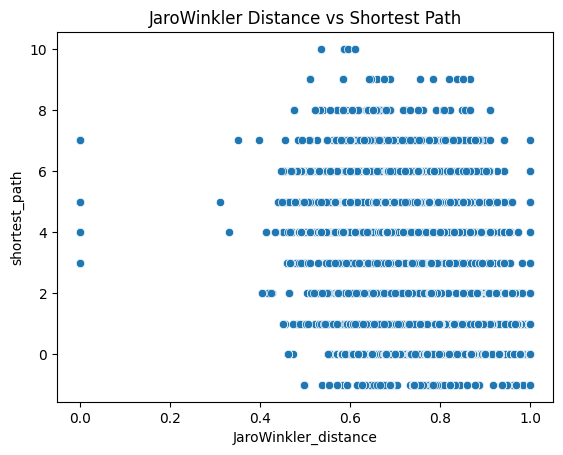

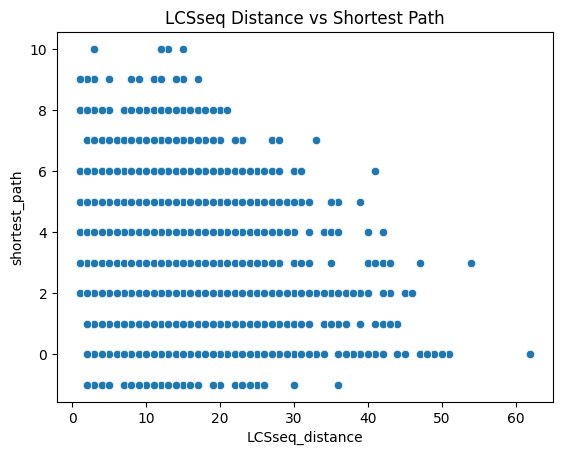

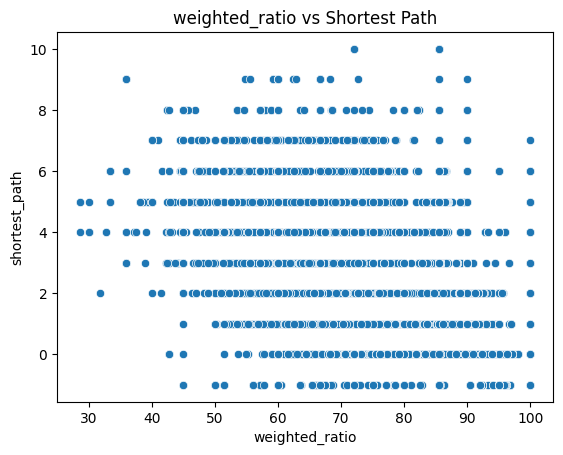

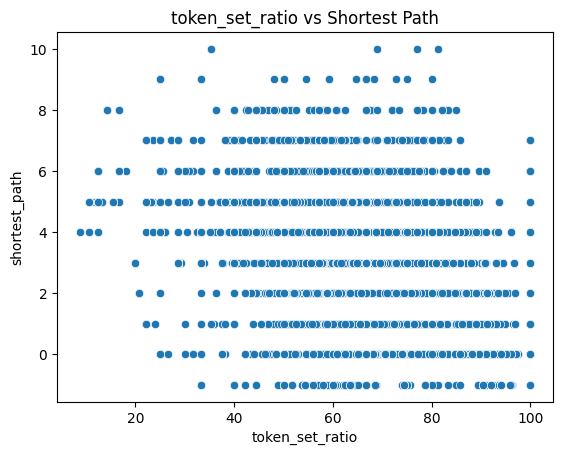

In [37]:
sns.scatterplot(x='JaroWinkler_distance', y='shortest_path', data=flat_predictions_df)
plt.title('JaroWinkler Distance vs Shortest Path')
plt.show()

sns.scatterplot(x='LCSseq_distance', y='shortest_path', data=flat_predictions_df)
plt.title('LCSseq Distance vs Shortest Path')
plt.show()

sns.scatterplot(x='weighted_ratio', y='shortest_path', data=flat_predictions_df)
plt.title('weighted_ratio vs Shortest Path')
plt.show()

sns.scatterplot(x='token_set_ratio', y='shortest_path', data=flat_predictions_df)
plt.title('token_set_ratio vs Shortest Path')
plt.show()

Since `token_set_ratio` and `weighted_ratio` have the strongest correlations, we will continue using these metrics as primary factors in the ranking process. Based on the correlation alanysis we will continue using `JaroWinkler_distance` as a secondary criterion, and `LCSseq_distance` will be the last metric used in the ranking process, as it shows the lowest correlation.

In [48]:
first_candidates = [sublist[0] for sublist in combined_predicted_values_with_shortest_path]
first_candidates_df = pd.DataFrame(first_candidates)

In [80]:
incorrect_predictions_df = first_candidates_df[first_candidates_df['is_correct'] == False].drop_duplicates(subset=['True MESH_ID', 'True Description'])
correct_predictions_df = first_candidates_df[first_candidates_df['is_correct'] == True].drop_duplicates(subset=['True MESH_ID', 'True Description'])

In [86]:
incorrect_predictions_df.drop(incorrect_predictions_df[incorrect_predictions_df['shortest_path'] == -1].index, inplace=True)
incorrect_predictions_df.drop(incorrect_predictions_df[incorrect_predictions_df['shortest_path'] == -2].index, inplace=True)

incorrect_predictions_df.sort_values(by='shortest_path', ascending=True).head(10)

,MESH_ID,Description,Synonyms,AltDiseaseIDs,score,weighted_ratio,token_set_ratio,JaroWinkler_distance,LCSseq_distance,True MESH_ID,True Description,is_correct,shortest_path
2574,MESH:C538402,Aspartylglucosamidase (AGA) deficiency,Aspartylglucosaminidase Deficiency|Glycosylasp...,NaN,9.570722,85.500000,78.048780,0.626792,22,MESH:D054880,deficiency of the enzyme aspartylglucosaminidase,False,1
569,MESH:D056728,"von Willebrand Disease, Type 2",Type 2A von Willebrand Disease|Type 2B von Wil...,DO:DOID:0060574|OMIM:613554,22.275431,90.000000,91.525424,0.960400,27,MESH:D014842,von Willebrand disease type B,False,1
1024,MESH:C536782,T-cell lymphoma 1A,NaN,NaN,0.942473,95.000000,100.000000,0.966667,15,MESH:D016399,T-cell lymphoma,False,1
2613,MESH:D056729,"von Willebrand Disease, Type 3",Type 3 Von Willebrand's Disease|Type 3 VWD|Von...,DO:DOID:0111054|OMIM:277480,4.908222,72.000000,57.142857,0.730000,3,MESH:D014842,vWD,False,1
1023,MESH:C554498,AIDS-related Kaposi sarcoma,NaN,NaN,0.950114,90.000000,100.000000,0.491182,14,MESH:D012514,Kaposi sarcoma,False,1
1022,MESH:C537762,"Chromosome 5, uniparental disomy",Mosaic trisomy of chromosome 5|Uniparental dis...,NaN,0.916233,90.000000,100.000000,0.894525,18,MESH:D024182,uniparental disomy,False,1
2638,MESH:C535399,"Charcot-Marie-Tooth disease, dominant intermed...",NaN,NaN,0.923242,85.500000,89.361702,0.856689,24,MESH:D002607,Charcot-Marie-Tooth type 1,False,1
3888,MESH:D000071960,Breast Carcinoma In Situ,"LCIS, Lobular Carcinoma In Situ|Lobular Carcin...",DO:DOID:8791,9.107054,62.181818,65.454545,0.610215,14,MESH:D001943,non-inherited breast carcinomas,False,1
597,MESH:C535818,Pseudo-Zellweger syndrome,Pseudo Zellweger syndrome leukodystrophy,DO:DOID:14723,10.768651,85.500000,81.818182,0.779649,18,MESH:D015211,Zellwegers syndrome,False,1
609,MESH:C538265,Attenuated familial adenomatous polyposis,"Familial Adenomatous Polyposis, Attenuated",NaN,19.588270,95.000000,100.000000,0.799458,30,MESH:D011125,familial adenomatous polyposis,False,1


As we can see, the most problematic diseases are those, which essentially denote different types of a disease (e.g., "T-cell lymphoma 1A" vs. "T-cell lymphoma", "von Willebrand Disease, Type 2" vs. "von Willebrand disease type B" etc.) and might have "parent-child" relationships (e.g. "Chromosome 5, uniparental disomy" is a child node of "uniparental disomy"). Let us explore these cases closer.

In [95]:
uniparental_disomy_df = pd.DataFrame(combined_predicted_values_with_shortest_path[1022])
uniparental_disomy_df.head()

,MESH_ID,Description,Synonyms,AltDiseaseIDs,score,weighted_ratio,token_set_ratio,JaroWinkler_distance,LCSseq_distance,True MESH_ID,True Description,is_correct,shortest_path
0,MESH:C537762,"Chromosome 5, uniparental disomy",Mosaic trisomy of chromosome 5|Uniparental dis...,NaN,0.916233,90.0,100.0,0.894525,18,MESH:D024182,uniparental disomy,False,1
1,MESH:C536469,Uniparental disomy of 13,Maternal uniparental disomy 13|Maternal unipar...,NaN,17.159235,90.0,100.0,0.884259,18,MESH:D024182,uniparental disomy,False,1
2,MESH:C536468,Uniparental disomy of 11,Paternal uniparental disomy for chromosome 11(...,NaN,16.280228,90.0,100.0,0.884259,18,MESH:D024182,uniparental disomy,False,1
3,MESH:C538043,"Chromosome 16, uniparental disomy",Uniparental disomy of 16,NaN,15.121084,90.0,100.0,0.884259,18,MESH:D024182,uniparental disomy,False,1
4,MESH:C536469,Uniparental disomy of 13,Maternal uniparental disomy 13|Maternal unipar...,NaN,0.943669,90.0,100.0,0.884259,18,MESH:D024182,uniparental disomy,False,1


We can try to increase the limit of the candidates.

In [140]:
def combined_search(disease_name: str, embedding: list, driver: Driver) -> dict:
    fulltext_predictions = fulltext_search(
        query=fulltext_index_query,
        disease_name=disease_name,
        driver=driver,
        limit=100
    )

    name_vector_predictions = vector_index_search(
        driver=driver,
        query=vector_index_query,
        embedding=embedding,
        index=Vectors.BAAI_DISEASE_NAME.value,
        limit=100,
        threshold=0.80
    )
    
    centroid_synonyms_vector_predictions = vector_index_search(
        driver=driver,
        query=vector_index_query,
        embedding=embedding,
        index=Vectors.BAAI_DISEASE_SYNONYMS_CENTROID.value,
        limit=100,
        threshold=0.80
    )

    fulltext_predictions = process_predictions(fulltext_predictions, disease_name)
    name_vector_predictions = process_predictions(name_vector_predictions, disease_name)
    centroid_synonyms_vector_predictions = process_predictions(centroid_synonyms_vector_predictions, disease_name)

    # Combine all predictions and sort
    combined = fulltext_predictions + name_vector_predictions + centroid_synonyms_vector_predictions
    combined = sorted(combined, key=lambda candidate: custom_sort_key(candidate, disease_name))

    return combined[0:100]

In [100]:
test = combined_search(disease_name="uniparental disomy", embedding=[-0.00298042013309896, -0.007240018341690302, -0.004846381954848766, 0.015482574701309204, -0.0322328545153141, -0.003963150084018707, 0.010785268619656563, 0.047895051538944244, 0.017533257603645325, 0.01756385900080204, 0.03534343093633652, -0.04103608801960945, 0.010943225584924221, 0.035572998225688934, 0.028120331466197968, 0.02705305628478527, -0.017948513850569725, 0.010073414072394371, -0.07388003170490265, 0.031763624399900436, 0.08600422739982605, 0.004979658406227827, -0.004505836870521307, 0.016609428450465202, -0.031867869198322296, 0.014919383451342583, -0.02031097561120987, -0.011255288496613503, -0.06520824134349823, -0.11296963691711426, -0.017000628635287285, 0.07300122827291489, 0.007550621870905161, -0.019680272787809372, 0.0942348837852478, -0.010655282996594906, -0.016780002042651176, 0.00975220836699009, -0.0423344150185585, 0.0019688252359628677, 0.01965542510151863, 0.019089875742793083, -0.02989404834806919, -0.07519310712814331, 0.03531509265303612, -0.04742462560534477, -0.039921022951602936, 0.021374600008130074, 0.130405455827713, -0.012297104112803936, -0.010949769988656044, 0.010290853679180145, 0.04470684379339218, -0.0008772607543505728, -0.042993269860744476, 0.023467540740966797, 0.06911574304103851, -0.004191834479570389, 0.06118451803922653, 0.04141899570822716, 0.006486865226179361, 0.01954856887459755, -0.11247993260622025, 0.0762946605682373, 0.06143694370985031, 0.001024325960315764, -0.0184955932199955, -0.05928066745400429, 0.034275490790605545, -0.0018031838117167354, 0.069577656686306, -0.020798441022634506, 0.07353554666042328, 0.06477884203195572, -0.003099297871813178, -0.011199251748621464, 0.05460735410451889, -0.04841795563697815, -0.026846954599022865, 0.012603324837982655, -0.050926342606544495, -0.053638163954019547, -0.005534856114536524, -0.030345655977725983, 0.0012148934183642268, -0.00963344145566225, -0.09881860017776489, -0.033432506024837494, -0.044339705258607864, -0.01964464597404003, -0.038099516183137894, -0.05867289751768112, 0.012133738957345486, -0.0011668027145788074, -0.0379972942173481, 0.04392446577548981, 0.02084236592054367, -0.055837806314229965, -0.002082124585285783, 0.3808797299861908, -0.029069693759083748, 0.027281345799565315, 0.011917761527001858, -0.025260822847485542, -0.049287378787994385, 0.08245984464883804, -0.04632845148444176, -0.043462689965963364, -0.06000027433037758, 0.0024532137904316187, 0.03259751945734024, -0.019134683534502983, 0.16248182952404022, -0.0412825383245945, -0.017392529174685478, -0.04689987376332283, 0.027208711951971054, 0.04023991897702217, -0.015171804465353489, 0.058631327003240585, 0.006094840820878744, -0.04436566308140755, 0.054443180561065674, -0.015888022258877754, 0.023309674113988876, -0.032225653529167175, -0.009731118567287922, 0.07608503848314285, 0.023300714790821075, 0.007572856266051531, 0.0074812802486121655, 0.03839900717139244, -0.010545644909143448, -0.026628855615854263, -0.023024866357445717, -0.023828638717532158, 0.019427435472607613, -0.05133621394634247, 0.024817848578095436, -0.09397437423467636, 0.004147300962358713, -0.10838678479194641, -0.09685449302196503, -0.04910945147275925, -0.030073905363678932, 0.02934182435274124, -0.05100617930293083, 0.04194944351911545, 0.007315801922231913, 0.03446376696228981, -0.02703874185681343, -0.04432087391614914, -0.016302527859807014, -0.03542235121130943, -0.004510939586907625, -0.025636430829763412, -0.03214607015252113, 0.017467554658651352, 0.021907484158873558, 0.020393021404743195, 0.09566521644592285, -0.08997124433517456, -0.010865451768040657, 0.044379375874996185, -0.035989344120025635, -0.015674570575356483, -0.03450118005275726, 0.007951248437166214, -0.010030997917056084, -0.048673246055841446, 0.02607511729001999, -0.02296956069767475, 0.00856051780283451, -0.035398393869400024, 0.05578889697790146, -0.00934244692325592, 0.07125997543334961, -0.00692339800298214, 0.06635180860757828, 0.05906596779823303, 0.04107847437262535, -0.049627698957920074, -0.027425790205597878, 0.030029350891709328, 0.015116636641323566, -0.04761786386370659, 0.03744446486234665, -0.016252873465418816, 0.07334327697753906, 0.047041211277246475, -0.07633396983146667, -0.03363323584198952, -0.03614737465977669, -0.03950436785817146, 0.00035868678241968155, -0.03622398152947426, -0.034307390451431274, -0.02787606418132782, 0.04718460142612457, -0.009734340943396091, 0.047557223588228226, 0.05068287253379822, 0.04750429838895798, 0.02581305429339409, 0.05240712687373161, 0.04673289507627487, 0.036018647253513336, -0.057927317917346954, 0.06691798567771912, 0.031537238508462906, -0.0009090814855881035, 0.014090245589613914, 0.06221088394522667, -0.019849928095936775, -0.00983097031712532, 0.08302801847457886, 0.034983158111572266, -0.0215775053948164, 0.04257681220769882, 0.006741547957062721, 0.04285727068781853, -0.05710085108876228, -0.00957213994115591, -0.33071383833885193, 0.026390433311462402, -0.011794169433414936, -0.09768501669168472, -0.01053574588149786, -0.02976098656654358, -0.03317536413669586, -0.014796129427850246, -0.010167742148041725, -0.018935980275273323, 0.012629471719264984, 0.021445628255605698, -0.01327505148947239, 0.056454867124557495, -0.010742628015577793, 0.019121984019875526, 0.04103218391537666, 0.028145089745521545, -0.0036613100674003363, 0.01887403056025505, -0.03433306887745857, 0.044103700667619705, 0.01141429878771305, 0.02819565124809742, 0.05839112028479576, -0.022914232686161995, 0.15651778876781464, 0.006761194206774235, 0.007008387707173824, -0.0018229003762826324, -0.01100380439311266, 0.06654390692710876, -0.03188423812389374, -0.10101211071014404, 0.015014180913567543, 0.035825688391923904, 0.03481489047408104, -0.08231246471405029, 0.006705558393150568, -0.00682092783972621, -0.029781509190797806, 0.010769379325211048, -0.016801539808511734, 0.01427770871669054, -0.03840501233935356, 0.052179545164108276, -0.06753498315811157, -0.014992817305028439, -0.03762375935912132, 0.04203300550580025, 0.05491970106959343, -0.05790891870856285, 0.010313245467841625, 0.030048415064811707, 0.02987547591328621, -0.01647079549729824, -0.04795192554593086, -0.03505251184105873, -0.005277205258607864, -0.004238377325236797, 0.039492443203926086, -0.00012877194967586547, 0.02894146926701069, -0.08409035950899124, -0.009947123005986214, -0.010266853496432304, -0.035088442265987396, -0.0020883739925920963, 0.01846739649772644, -0.00875844806432724, -0.004228157922625542, 0.12503491342067719, -0.023030530661344528, -0.01325258519500494, 0.018495000898838043, 0.04944217577576637, 0.0352187342941761, 0.017764365300536156, -0.08087791502475739, -0.015051006339490414, 0.014349880628287792, 0.005247393157333136, -0.031100232154130936, 0.03458113968372345, -0.030176009982824326, -0.03944198042154312, -0.06918521970510483, -0.02932378463447094, 0.006397074554115534, -0.0596553310751915, 0.011533703655004501, 0.06479205936193466, -0.04049328342080116, 0.03145202621817589, 0.03047890216112137, 0.01199861615896225, -0.2553052604198456, -0.030245676636695862, -0.07545354217290878, 0.0010600709356367588, -0.012022455222904682, 0.00034676652285270393, 0.010529552586376667, 0.03936539590358734, -0.06465904414653778, 0.029291467741131783, -0.05813414230942726, -0.0032296476420015097, 0.02007954567670822, -0.004092673771083355, -0.0006570667610503733, -0.013764951378107071, 0.048250943422317505, -0.006680822931230068, -0.030779728665947914, -0.04446592554450035, 0.01524774357676506, 0.0331680066883564, 0.11865027993917465, -0.006669038441032171, -0.0519922710955143, 0.03309360519051552, -0.025029852986335754, 0.07211172580718994, -0.05231283977627754, 0.00710005359724164, -0.028000086545944214, 0.04012596607208252, 0.006803113967180252, -0.027242422103881836, -0.00194108160212636, -0.0020234487019479275, -0.018998553976416588, 0.014308357611298561, 0.02491811290383339, -0.023898009210824966, 0.008898916654288769, 0.010956043377518654, 0.011914919130504131, 0.0042448327876627445, 0.042476195842027664, 0.0175836980342865, -0.024241700768470764, 0.07090618461370468, 0.030943337827920914, -9.396976383868605e-05, -0.034073103219270706, -0.007863895036280155, 0.06770700216293335, 0.0492732971906662, 0.04176836833357811, -0.042379483580589294, -0.014101622626185417, 0.014816105365753174, 0.025231599807739258, -0.011439158581197262, -0.014915697276592255, -0.0143996961414814, -0.018628211691975594, 0.0805368572473526, 0.012521516531705856], driver=driver)

In [102]:
[test[i] for i, item in enumerate(test) if item['MESH_ID'] == 'MESH:D024182']

[{'MESH_ID': 'MESH:D024182',
  'Description': 'Uniparental Disomy',
  'Synonyms': 'Disomies, Uniparental|Disomy, Uniparental|Heterodisomies, Uniparental|Heterodisomy, Uniparental|Isodisomies, Uniparental|Uniparental Disomies|Uniparental Heterodisomies|Uniparental Heterodisomy|Uniparental Isodisomies|Uniparental Isodisomy',
  'AltDiseaseIDs': nan,
  'score': 18.263681411743164,
  'weighted_ratio': 88.88888888888889,
  'token_set_ratio': 88.88888888888889,
  'JaroWinkler_distance': 0.9259259259259259,
  'LCSseq_distance': 17},
 {'MESH_ID': 'MESH:D024182',
  'Description': 'Uniparental Disomy',
  'Synonyms': 'Disomies, Uniparental|Disomy, Uniparental|Heterodisomies, Uniparental|Heterodisomy, Uniparental|Isodisomies, Uniparental|Uniparental Disomies|Uniparental Heterodisomies|Uniparental Heterodisomy|Uniparental Isodisomies|Uniparental Isodisomy',
  'AltDiseaseIDs': nan,
  'score': 1.0,
  'weighted_ratio': 88.88888888888889,
  'token_set_ratio': 88.88888888888889,
  'JaroWinkler_distance':

As we can see, we did get the correct node in the combined predictions, but it got lowered by the candidates re-ranking (although it was the first candidate in the fulltext index). Let us modify our search more.

In [105]:
def find_all_direct_vector_hits(candidates):
    return [d for d in candidates if d.get('score') == 1.0]

In [141]:
def combined_search(disease_name: str, embedding: list, driver: Driver) -> dict:
    fulltext_predictions = fulltext_search(
        query=fulltext_index_query,
        disease_name=disease_name,
        driver=driver,
        limit=100
    )

    name_vector_predictions = vector_index_search(
        driver=driver,
        query=vector_index_query,
        embedding=embedding,
        index=Vectors.BAAI_DISEASE_NAME.value,
        limit=100,
        threshold=0.80
    )
    
    centroid_synonyms_vector_predictions = vector_index_search(
        driver=driver,
        query=vector_index_query,
        embedding=embedding,
        index=Vectors.BAAI_DISEASE_SYNONYMS_CENTROID.value,
        limit=100,
        threshold=0.80
    )

    name_vec_direct_hits = find_all_direct_vector_hits(name_vector_predictions)
    centroid_direct_hits = find_all_direct_vector_hits(centroid_synonyms_vector_predictions)

    if len(name_vec_direct_hits) > 0 or len(centroid_direct_hits) > 0:
        return name_vec_direct_hits + centroid_direct_hits
    else:
        fulltext_predictions = process_predictions(fulltext_predictions, disease_name)
        name_vector_predictions = process_predictions(name_vector_predictions, disease_name)
        centroid_synonyms_vector_predictions = process_predictions(centroid_synonyms_vector_predictions, disease_name)

        # Combine all predictions and sort
        combined = fulltext_predictions + name_vector_predictions + centroid_synonyms_vector_predictions
        combined = sorted(combined, key=lambda candidate: custom_sort_key(candidate, disease_name))

        return combined[0:100]

In [112]:
test = combined_search(disease_name="uniparental disomy", embedding=[-0.00298042013309896, -0.007240018341690302, -0.004846381954848766, 0.015482574701309204, -0.0322328545153141, -0.003963150084018707, 0.010785268619656563, 0.047895051538944244, 0.017533257603645325, 0.01756385900080204, 0.03534343093633652, -0.04103608801960945, 0.010943225584924221, 0.035572998225688934, 0.028120331466197968, 0.02705305628478527, -0.017948513850569725, 0.010073414072394371, -0.07388003170490265, 0.031763624399900436, 0.08600422739982605, 0.004979658406227827, -0.004505836870521307, 0.016609428450465202, -0.031867869198322296, 0.014919383451342583, -0.02031097561120987, -0.011255288496613503, -0.06520824134349823, -0.11296963691711426, -0.017000628635287285, 0.07300122827291489, 0.007550621870905161, -0.019680272787809372, 0.0942348837852478, -0.010655282996594906, -0.016780002042651176, 0.00975220836699009, -0.0423344150185585, 0.0019688252359628677, 0.01965542510151863, 0.019089875742793083, -0.02989404834806919, -0.07519310712814331, 0.03531509265303612, -0.04742462560534477, -0.039921022951602936, 0.021374600008130074, 0.130405455827713, -0.012297104112803936, -0.010949769988656044, 0.010290853679180145, 0.04470684379339218, -0.0008772607543505728, -0.042993269860744476, 0.023467540740966797, 0.06911574304103851, -0.004191834479570389, 0.06118451803922653, 0.04141899570822716, 0.006486865226179361, 0.01954856887459755, -0.11247993260622025, 0.0762946605682373, 0.06143694370985031, 0.001024325960315764, -0.0184955932199955, -0.05928066745400429, 0.034275490790605545, -0.0018031838117167354, 0.069577656686306, -0.020798441022634506, 0.07353554666042328, 0.06477884203195572, -0.003099297871813178, -0.011199251748621464, 0.05460735410451889, -0.04841795563697815, -0.026846954599022865, 0.012603324837982655, -0.050926342606544495, -0.053638163954019547, -0.005534856114536524, -0.030345655977725983, 0.0012148934183642268, -0.00963344145566225, -0.09881860017776489, -0.033432506024837494, -0.044339705258607864, -0.01964464597404003, -0.038099516183137894, -0.05867289751768112, 0.012133738957345486, -0.0011668027145788074, -0.0379972942173481, 0.04392446577548981, 0.02084236592054367, -0.055837806314229965, -0.002082124585285783, 0.3808797299861908, -0.029069693759083748, 0.027281345799565315, 0.011917761527001858, -0.025260822847485542, -0.049287378787994385, 0.08245984464883804, -0.04632845148444176, -0.043462689965963364, -0.06000027433037758, 0.0024532137904316187, 0.03259751945734024, -0.019134683534502983, 0.16248182952404022, -0.0412825383245945, -0.017392529174685478, -0.04689987376332283, 0.027208711951971054, 0.04023991897702217, -0.015171804465353489, 0.058631327003240585, 0.006094840820878744, -0.04436566308140755, 0.054443180561065674, -0.015888022258877754, 0.023309674113988876, -0.032225653529167175, -0.009731118567287922, 0.07608503848314285, 0.023300714790821075, 0.007572856266051531, 0.0074812802486121655, 0.03839900717139244, -0.010545644909143448, -0.026628855615854263, -0.023024866357445717, -0.023828638717532158, 0.019427435472607613, -0.05133621394634247, 0.024817848578095436, -0.09397437423467636, 0.004147300962358713, -0.10838678479194641, -0.09685449302196503, -0.04910945147275925, -0.030073905363678932, 0.02934182435274124, -0.05100617930293083, 0.04194944351911545, 0.007315801922231913, 0.03446376696228981, -0.02703874185681343, -0.04432087391614914, -0.016302527859807014, -0.03542235121130943, -0.004510939586907625, -0.025636430829763412, -0.03214607015252113, 0.017467554658651352, 0.021907484158873558, 0.020393021404743195, 0.09566521644592285, -0.08997124433517456, -0.010865451768040657, 0.044379375874996185, -0.035989344120025635, -0.015674570575356483, -0.03450118005275726, 0.007951248437166214, -0.010030997917056084, -0.048673246055841446, 0.02607511729001999, -0.02296956069767475, 0.00856051780283451, -0.035398393869400024, 0.05578889697790146, -0.00934244692325592, 0.07125997543334961, -0.00692339800298214, 0.06635180860757828, 0.05906596779823303, 0.04107847437262535, -0.049627698957920074, -0.027425790205597878, 0.030029350891709328, 0.015116636641323566, -0.04761786386370659, 0.03744446486234665, -0.016252873465418816, 0.07334327697753906, 0.047041211277246475, -0.07633396983146667, -0.03363323584198952, -0.03614737465977669, -0.03950436785817146, 0.00035868678241968155, -0.03622398152947426, -0.034307390451431274, -0.02787606418132782, 0.04718460142612457, -0.009734340943396091, 0.047557223588228226, 0.05068287253379822, 0.04750429838895798, 0.02581305429339409, 0.05240712687373161, 0.04673289507627487, 0.036018647253513336, -0.057927317917346954, 0.06691798567771912, 0.031537238508462906, -0.0009090814855881035, 0.014090245589613914, 0.06221088394522667, -0.019849928095936775, -0.00983097031712532, 0.08302801847457886, 0.034983158111572266, -0.0215775053948164, 0.04257681220769882, 0.006741547957062721, 0.04285727068781853, -0.05710085108876228, -0.00957213994115591, -0.33071383833885193, 0.026390433311462402, -0.011794169433414936, -0.09768501669168472, -0.01053574588149786, -0.02976098656654358, -0.03317536413669586, -0.014796129427850246, -0.010167742148041725, -0.018935980275273323, 0.012629471719264984, 0.021445628255605698, -0.01327505148947239, 0.056454867124557495, -0.010742628015577793, 0.019121984019875526, 0.04103218391537666, 0.028145089745521545, -0.0036613100674003363, 0.01887403056025505, -0.03433306887745857, 0.044103700667619705, 0.01141429878771305, 0.02819565124809742, 0.05839112028479576, -0.022914232686161995, 0.15651778876781464, 0.006761194206774235, 0.007008387707173824, -0.0018229003762826324, -0.01100380439311266, 0.06654390692710876, -0.03188423812389374, -0.10101211071014404, 0.015014180913567543, 0.035825688391923904, 0.03481489047408104, -0.08231246471405029, 0.006705558393150568, -0.00682092783972621, -0.029781509190797806, 0.010769379325211048, -0.016801539808511734, 0.01427770871669054, -0.03840501233935356, 0.052179545164108276, -0.06753498315811157, -0.014992817305028439, -0.03762375935912132, 0.04203300550580025, 0.05491970106959343, -0.05790891870856285, 0.010313245467841625, 0.030048415064811707, 0.02987547591328621, -0.01647079549729824, -0.04795192554593086, -0.03505251184105873, -0.005277205258607864, -0.004238377325236797, 0.039492443203926086, -0.00012877194967586547, 0.02894146926701069, -0.08409035950899124, -0.009947123005986214, -0.010266853496432304, -0.035088442265987396, -0.0020883739925920963, 0.01846739649772644, -0.00875844806432724, -0.004228157922625542, 0.12503491342067719, -0.023030530661344528, -0.01325258519500494, 0.018495000898838043, 0.04944217577576637, 0.0352187342941761, 0.017764365300536156, -0.08087791502475739, -0.015051006339490414, 0.014349880628287792, 0.005247393157333136, -0.031100232154130936, 0.03458113968372345, -0.030176009982824326, -0.03944198042154312, -0.06918521970510483, -0.02932378463447094, 0.006397074554115534, -0.0596553310751915, 0.011533703655004501, 0.06479205936193466, -0.04049328342080116, 0.03145202621817589, 0.03047890216112137, 0.01199861615896225, -0.2553052604198456, -0.030245676636695862, -0.07545354217290878, 0.0010600709356367588, -0.012022455222904682, 0.00034676652285270393, 0.010529552586376667, 0.03936539590358734, -0.06465904414653778, 0.029291467741131783, -0.05813414230942726, -0.0032296476420015097, 0.02007954567670822, -0.004092673771083355, -0.0006570667610503733, -0.013764951378107071, 0.048250943422317505, -0.006680822931230068, -0.030779728665947914, -0.04446592554450035, 0.01524774357676506, 0.0331680066883564, 0.11865027993917465, -0.006669038441032171, -0.0519922710955143, 0.03309360519051552, -0.025029852986335754, 0.07211172580718994, -0.05231283977627754, 0.00710005359724164, -0.028000086545944214, 0.04012596607208252, 0.006803113967180252, -0.027242422103881836, -0.00194108160212636, -0.0020234487019479275, -0.018998553976416588, 0.014308357611298561, 0.02491811290383339, -0.023898009210824966, 0.008898916654288769, 0.010956043377518654, 0.011914919130504131, 0.0042448327876627445, 0.042476195842027664, 0.0175836980342865, -0.024241700768470764, 0.07090618461370468, 0.030943337827920914, -9.396976383868605e-05, -0.034073103219270706, -0.007863895036280155, 0.06770700216293335, 0.0492732971906662, 0.04176836833357811, -0.042379483580589294, -0.014101622626185417, 0.014816105365753174, 0.025231599807739258, -0.011439158581197262, -0.014915697276592255, -0.0143996961414814, -0.018628211691975594, 0.0805368572473526, 0.012521516531705856], driver=driver)

In [113]:
test

[{'MESH_ID': 'MESH:D024182',
  'Description': 'Uniparental Disomy',
  'Synonyms': 'Disomies, Uniparental|Disomy, Uniparental|Heterodisomies, Uniparental|Heterodisomy, Uniparental|Isodisomies, Uniparental|Uniparental Disomies|Uniparental Heterodisomies|Uniparental Heterodisomy|Uniparental Isodisomies|Uniparental Isodisomy',
  'AltDiseaseIDs': nan,
  'score': 1.0}]

In [142]:
predicted_values_v2 = get_combined_search_for_df(dataset=df, embedding_col='DiseaseEmbedding-BAAI-bge-small-en-v1_5', driver=driver)

In [143]:
mrr_score(predicted_values_v2)

0.6948893266503502

In [144]:
hits_at_n_score(predicted_values_v2, 1)

0.6622142306704342

In [145]:
hits_at_n_score(predicted_values_v2, 5)

0.7400462368353455

As we can see, the results are slightly better now (approx. by 2%), which suggests that using a direct hit from vector queries as well as increasing the pool of candidates does help. The next issue we will try to address is "types" in the disease names, which often confuse the ranking. We will update the `custom_sort_key()` by prioritizing exact mathes, handling disease types and penalizing broader matches.

In [138]:
def custom_sort_key(candidate: dict, disease_name: str) -> tuple:
    abbrev = contains_abbreviation(disease_name)

    # Original scoring metrics
    primary_metric = candidate['weighted_ratio'] if abbrev else candidate['token_set_ratio']
    secondary_metric = candidate['token_set_ratio'] if abbrev else candidate['weighted_ratio']
    tertiary_metric = candidate['JaroWinkler_distance']
    quaternary_metric = candidate['LCSseq_distance']

    # New scoring logic for prioritizing exact matches and subtypes
    exact_match = 0
    subtype_penalty = 0

    # Prioritize exact match
    if candidate['Description'].strip().lower() == disease_name.strip().lower():
        exact_match = 1

    # Penalize broader matches that miss subtype details
    if 'type' in disease_name.lower() and 'type' not in candidate['Description'].lower():
        subtype_penalty = -1
    

    # Return a tuple with the original metrics and the new factors
    return (
        -exact_match,                 # Higher priority for exact matches
        subtype_penalty,              # Penalize missing subtype information
        -primary_metric, 
        -secondary_metric, 
        -tertiary_metric, 
        -quaternary_metric
    )


In [134]:
predicted_values_v3 = get_combined_search_for_df(dataset=df, embedding_col='DiseaseEmbedding-BAAI-bge-small-en-v1_5', driver=driver)

In [135]:
mrr_score(predicted_values_v3)

0.7013352845422232

In [136]:
hits_at_n_score(predicted_values_v3, 1)

0.6696634985872079

In [137]:
hits_at_n_score(predicted_values_v3, 5)

0.7467248908296943

We can see a slight improvement in this (approx. 1%), which suggests that using more sofisticated sort function is beneficial.
The combined search strategy demonstrates a significant improvements in comparisong to the baseline:
- accuracy: 0.6696634985872079 (baseline: 0.52520366598778)
- mrr score: 0.7013352845422232
- hit@5 score: 0.7467248908296943

We will use this strategy and compare the performance using indices created on the embeddings from a different model.